In [6]:
import torch
from torch import nn
import numpy as np
import data_handling as dh
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
import torch.nn.init
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F

In [2]:
# Resetting model function
# Credits: https://discuss.pytorch.org/t/reset-model-weights/19180/4
def reset_model(model):
    for layer in model.children(): 
       if hasattr(layer, 'reset_parameters'): 
           layer.reset_parameters() 

In [3]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", torch.cuda.get_device_name(device)) 

Device: NVIDIA GeForce MX150


In [5]:
batch_size_train_ww =  16         # batch size during training
batch_size_test_ww = 100          # batch size for the test data
lr_adam_ww = 1e-3                 # learning rate for Adam optimizer
nepochs_ww = 100                  # number of epochs to run the training

In [9]:
class TargetTransformCrossEntropy():
    def __call__(self, target):
        tmparr = np.array(target)  # Needs to have shape HxW
        return torch.as_tensor(tmparr.astype(np.double)/255., dtype=torch.int64)

In [8]:
class ImgToTensor2Channels():
    def __init__(self, transform=transforms.ToTensor()):
        self.transform = transform
        
    def __call__(self, img):
        img = self.transform(img)
        return img[:2,...]

In [10]:
training_data_ww_int = dh.WarwickDataset('WARWICK/Train', target_transform=TargetTransformCrossEntropy())

mean, std = training_data_ww_int.get_stats_data()

mean /= 255.
std /= 255.

# std = 0 would not work in the data standardization
if std[2] == 0:  
    std[2] = 1

# Here we define our data stnadardization transform
transform = transforms.Compose([
    ImgToTensor2Channels(),
#    transforms.ToTensor(),                        # Convert image to tensor
#    transforms.Normalize(mean=mean, std=std),     # Standardize the input images
])

training_data_ww_int = dh.WarwickDataset('WARWICK/Train', transform=transform, 
                                         target_transform=TargetTransformCrossEntropy())

test_data_ww_int = dh.WarwickDataset('WARWICK/Test', transform=transform,
                                     target_transform=TargetTransformCrossEntropy())



dataloader_train_ww_int = DataLoader(training_data_ww_int, batch_size=batch_size_train_ww, shuffle=False)

X_test_data_ww_int, y_test_data_ww_int = test_data_ww_int.dataset2tensors()
X_test_data_ww_int = X_test_data_ww_int.to(device)
y_test_data_ww_int = y_test_data_ww_int.to(device)

loading
WARWICK/Train/image_01.png
WARWICK/Train/label_01.png
WARWICK/Train/image_02.png
WARWICK/Train/label_02.png
WARWICK/Train/image_03.png
WARWICK/Train/label_03.png
WARWICK/Train/image_04.png
WARWICK/Train/label_04.png
WARWICK/Train/image_05.png
WARWICK/Train/label_05.png
WARWICK/Train/image_06.png
WARWICK/Train/label_06.png
WARWICK/Train/image_07.png
WARWICK/Train/label_07.png
WARWICK/Train/image_08.png
WARWICK/Train/label_08.png
WARWICK/Train/image_09.png
WARWICK/Train/label_09.png
WARWICK/Train/image_10.png
WARWICK/Train/label_10.png
WARWICK/Train/image_11.png
WARWICK/Train/label_11.png
WARWICK/Train/image_12.png
WARWICK/Train/label_12.png
WARWICK/Train/image_13.png
WARWICK/Train/label_13.png
WARWICK/Train/image_14.png
WARWICK/Train/label_14.png
WARWICK/Train/image_15.png
WARWICK/Train/label_15.png
WARWICK/Train/image_16.png
WARWICK/Train/label_16.png
WARWICK/Train/image_17.png
WARWICK/Train/label_17.png
WARWICK/Train/image_18.png
WARWICK/Train/label_18.png
WARWICK/Train/image_

In [20]:
.shape

torch.Size([85, 2, 128, 128])

In [17]:
print([x[0] for x in dataloader_train_ww_int.dataset])

[tensor([[[0.5882, 0.6196, 0.5255,  ..., 0.4000, 0.0706, 0.1294],
         [0.4157, 0.6078, 0.6157,  ..., 0.2471, 0.1020, 0.0902],
         [0.5569, 0.6706, 0.6471,  ..., 0.0745, 0.4353, 0.3373],
         ...,
         [0.6431, 0.4471, 0.4157,  ..., 0.3098, 0.5961, 0.0431],
         [0.6392, 0.4471, 0.5412,  ..., 0.3961, 0.5922, 0.2431],
         [0.4863, 0.3098, 0.5098,  ..., 0.2588, 0.5176, 0.5373]],

        [[0.7059, 0.7373, 0.7216,  ..., 0.7216, 0.6196, 0.7020],
         [0.6549, 0.6863, 0.7059,  ..., 0.7020, 0.6157, 0.6431],
         [0.7569, 0.7412, 0.6980,  ..., 0.6824, 0.6941, 0.6941],
         ...,
         [0.7725, 0.6706, 0.5882,  ..., 0.6510, 0.6863, 0.5686],
         [0.7529, 0.7569, 0.7176,  ..., 0.6510, 0.6745, 0.6275],
         [0.6784, 0.7176, 0.7294,  ..., 0.6706, 0.6863, 0.7765]]]), tensor([[[0.2275, 0.1373, 0.4549,  ..., 0.0510, 0.2000, 0.0196],
         [0.2588, 0.0549, 0.0549,  ..., 0.0275, 0.2471, 0.1137],
         [0.0235, 0.1176, 0.0431,  ..., 0.0471, 0.1216, 

In [8]:
init_model = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
                nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
)


init_model_small = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1),
                nn.Conv2d(in_channels=4, out_channels=2, kernel_size=1, stride=1, padding=0),
)


init_model_do = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.25),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.25),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.25),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
                nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
)




init_model_dc = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2,2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
                nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
)


model_bn = nn.Sequential(
                nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.MaxPool2d(2,2),
                nn.ReLU(),
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
                nn.ReLU(),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
                nn.Conv2d(in_channels=8, out_channels=2, kernel_size=1, stride=1, padding=0),
)



In [9]:
def xavier_init(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)


In [10]:
model = init_model_small
#model.apply(xavier_init)

model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam_ww)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr_adam_ww)
softmax2d = torch.nn.Softmax(dim=1)

In [11]:
dataloader_train_ww_int.dataset[0]

(tensor([[[0.5882, 0.6196, 0.5255,  ..., 0.4000, 0.0706, 0.1294],
          [0.4157, 0.6078, 0.6157,  ..., 0.2471, 0.1020, 0.0902],
          [0.5569, 0.6706, 0.6471,  ..., 0.0745, 0.4353, 0.3373],
          ...,
          [0.6431, 0.4471, 0.4157,  ..., 0.3098, 0.5961, 0.0431],
          [0.6392, 0.4471, 0.5412,  ..., 0.3961, 0.5922, 0.2431],
          [0.4863, 0.3098, 0.5098,  ..., 0.2588, 0.5176, 0.5373]],
 
         [[0.7059, 0.7373, 0.7216,  ..., 0.7216, 0.6196, 0.7020],
          [0.6549, 0.6863, 0.7059,  ..., 0.7020, 0.6157, 0.6431],
          [0.7569, 0.7412, 0.6980,  ..., 0.6824, 0.6941, 0.6941],
          ...,
          [0.7725, 0.6706, 0.5882,  ..., 0.6510, 0.6863, 0.5686],
          [0.7529, 0.7569, 0.7176,  ..., 0.6510, 0.6745, 0.6275],
          [0.6784, 0.7176, 0.7294,  ..., 0.6706, 0.6863, 0.7765]]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,

In [12]:
np.array(training_data_ww_int.data[0])/255.

array([[[0.58823529, 0.70588235, 0.        ],
        [0.61960784, 0.7372549 , 0.        ],
        [0.5254902 , 0.72156863, 0.        ],
        ...,
        [0.4       , 0.72156863, 0.        ],
        [0.07058824, 0.61960784, 0.        ],
        [0.12941176, 0.70196078, 0.        ]],

       [[0.41568627, 0.65490196, 0.        ],
        [0.60784314, 0.68627451, 0.        ],
        [0.61568627, 0.70588235, 0.        ],
        ...,
        [0.24705882, 0.70196078, 0.        ],
        [0.10196078, 0.61568627, 0.        ],
        [0.09019608, 0.64313725, 0.        ]],

       [[0.55686275, 0.75686275, 0.        ],
        [0.67058824, 0.74117647, 0.        ],
        [0.64705882, 0.69803922, 0.        ],
        ...,
        [0.0745098 , 0.68235294, 0.        ],
        [0.43529412, 0.69411765, 0.        ],
        [0.3372549 , 0.69411765, 0.        ]],

       ...,

       [[0.64313725, 0.77254902, 0.        ],
        [0.44705882, 0.67058824, 0.        ],
        [0.41568627, 0

In [13]:
class DetermineCorrectImageSegmentationDSC():

    def __init__(self):
        self.softmax2d = nn.Softmax2d()
    
    def __call__(self, pred, target):
        
        a = self.softmax2d(pred).argmax(1).bool()
        b = target.bool()
        intersect = torch.logical_and(a,b)
        return [{'intersect':  intersect, 'a': a, 'b': b}]
    


class CorrectToAccuracy():
    def __call__(self, correct, size):
        tmpinter = [x['intersect'] for x in correct]
        tmpa = [x['a'] for x in correct]
        tmpb = [x['b'] for x in correct]

        intersect = torch.cat(tmpinter, dim=0)
        a = torch.cat(tmpa, dim=0)
        b = torch.cat(tmpb, dim=0)
        dice_coeff = (2.0 * intersect.sum()) / (a.sum() + b.sum())
        return dice_coeff


In [14]:
def compute_dsc(pred, target):
    a = softmax2d(pred).argmax(1).bool()
    b = target.bool()
    intersect = torch.logical_and(a,b)
    dice_coeff = (2.0 * intersect.sum(dim=(-1,-2))) / (a.sum(dim=(-1,-2)) + b.sum(dim=(-1,-2)))
    return dice_coeff

In [15]:
def evaluate(model, loss_fn, device, dataloader=None, Xdata=None, ydata=None):

    model.eval()
    loss_val, dsc = 0, []
    
    with torch.no_grad():
        if dataloader is not None:
            size = len(dataloader.dataset)
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss_val += loss_fn(pred, y).item() * X.shape[0]
                dsc += compute_dsc(pred, y)
            loss_val /= size
        else:
            pred = model(Xdata)
            loss_val += loss_fn(pred, ydata).item()
            dsc += compute_dsc(pred, ydata)
    
    dsc = torch.tensor(dsc).numpy()
    return loss_val, dsc

In [16]:
log = []

iteration = 0

print('%9s %9s %9s %9s %9s' % ('EPOCH', 'ITERATION', 'DATASET', 'COST', 'Mean DSC'))


loss_val, dsc = evaluate(model, loss_fn, device, 
                         Xdata=X_test_data_ww_int,
                         ydata=y_test_data_ww_int)

log_entry = {
    'epoch':                 0,
    'iteration':             0,
    'dsc':                 dsc,
    'dsc_mean':     dsc.mean(),
    'loss':           loss_val,
    'dataset':          'init',
}

log.append(log_entry)

print('%9i %9i %9s %9.3f %9.2f' % (0, 0, 'INIT', loss_val, dsc.mean()))



for epoch in range(nepochs_ww):
    
    start_time = timer()
    
    for ibatch, (X, y) in enumerate(dataloader_train_ww_int):
        model.train()
        
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Evaluta performance data on batch
        dsc = compute_dsc(pred, y).cpu().numpy()
        loss_val = loss.item()
        
        log_entry = {
            'epoch':             epoch,
            'iteration':     iteration,
            'dsc':                 dsc,
            'dsc_mean':     dsc.mean(),
            'loss':           loss_val,
            'dataset':   'train_batch',
        }
        
        log.append(log_entry)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Evaluate the model on the test data
        loss_val, dsc = evaluate(model, loss_fn, device, 
                                 Xdata=X_test_data_ww_int,
                                 ydata=y_test_data_ww_int)
        
        log_entry = {
            'epoch':             epoch,
            'iteration':     iteration,
            'dsc':                 dsc,
            'dsc_mean':     dsc.mean(),
            'loss':           loss_val,
            'dataset':          'test',
        }
        
        log.append(log_entry)
        
        print('%9i %9i %9s %9.3f %9.2f' % (epoch, iteration, 'TEST', loss_val, dsc.mean()))
        
        
#        # Evaluate the model on all training data
#        loss_val, dsc = evaluate(model, loss_fn, device, dataloader=dataloader_train_ww_int,)
#        
#        log_entry = {
#            'epoch':             epoch,
#            'iteration':     iteration,
#            'dsc':                 dsc,
#            'dsc_mean':     dsc.mean(),
#            'loss':           loss_val,
#            'dataset':         'train',
#        }
#        
#        log.append(log_entry)
#                
#        print('%9i %9i %9s %9.3f %9.2f' % (epoch, iteration, 'TRAIN', loss_val, dsc.mean()))


        iteration += 1
    
    end_time = timer()
    elapsed = end_time - start_time
    
    log_entry = {
        'epoch':             epoch,
        'start_time':   start_time,
        'end_time':       end_time,
        'elapsed_time':    elapsed,
        'dataset':         'timer',
    }
    
    log.append(log_entry)


    EPOCH ITERATION   DATASET      COST  Mean DSC
        0         0      INIT     0.694      0.00
        0         0      TEST     0.694      0.00
        0         1      TEST     0.694      0.00
        0         2      TEST     0.694      0.00
        0         3      TEST     0.694      0.00
        0         4      TEST     0.694      0.00
        0         5      TEST     0.694      0.00
        1         6      TEST     0.694      0.00
        1         7      TEST     0.694      0.00
        1         8      TEST     0.694      0.00
        1         9      TEST     0.693      0.00
        1        10      TEST     0.693      0.13
        1        11      TEST     0.693      0.35
        2        12      TEST     0.693      0.46
        2        13      TEST     0.694      0.52
        2        14      TEST     0.694      0.58
        2        15      TEST     0.695      0.60
        2        16      TEST     0.697      0.62
        2        17      TEST     0.700      0.63


       27       163      TEST     0.690      0.59
       27       164      TEST     0.727      0.62
       27       165      TEST     0.673      0.57
       27       166      TEST     0.665      0.44
       27       167      TEST     0.660      0.49
       28       168      TEST     0.672      0.59
       28       169      TEST     0.715      0.62
       28       170      TEST     0.717      0.62
       28       171      TEST     0.656      0.55
       28       172      TEST     0.662      0.42
       28       173      TEST     0.651      0.52
       29       174      TEST     0.674      0.61
       29       175      TEST     0.722      0.63
       29       176      TEST     0.712      0.63
       29       177      TEST     0.648      0.57
       29       178      TEST     0.654      0.43
       29       179      TEST     0.644      0.51
       30       180      TEST     0.656      0.61
       30       181      TEST     0.709      0.63
       30       182      TEST     0.727      0.63


       55       330      TEST     0.549      0.75
       55       331      TEST     0.545      0.75
       55       332      TEST     0.492      0.75
       55       333      TEST     0.543      0.76
       55       334      TEST     0.495      0.76
       55       335      TEST     0.489      0.75
       56       336      TEST     0.543      0.76
       56       337      TEST     0.547      0.76
       56       338      TEST     0.488      0.75
       56       339      TEST     0.530      0.76
       56       340      TEST     0.497      0.77
       56       341      TEST     0.484      0.74
       57       342      TEST     0.536      0.76
       57       343      TEST     0.555      0.76
       57       344      TEST     0.482      0.75
       57       345      TEST     0.511      0.77
       57       346      TEST     0.516      0.77
       57       347      TEST     0.488      0.73
       58       348      TEST     0.508      0.77
       58       349      TEST     0.614      0.74


       82       496      TEST     0.471      0.78
       82       497      TEST     0.490      0.78
       83       498      TEST     0.462      0.77
       83       499      TEST     0.484      0.78
       83       500      TEST     0.521      0.78
       83       501      TEST     0.457      0.78
       83       502      TEST     0.457      0.78
       83       503      TEST     0.497      0.78
       84       504      TEST     0.466      0.78
       84       505      TEST     0.470      0.78
       84       506      TEST     0.508      0.78
       84       507      TEST     0.464      0.79
       84       508      TEST     0.454      0.78
       84       509      TEST     0.475      0.79
       85       510      TEST     0.470      0.78
       85       511      TEST     0.479      0.78
       85       512      TEST     0.482      0.78
       85       513      TEST     0.462      0.79
       85       514      TEST     0.463      0.79
       85       515      TEST     0.463      0.78


In [17]:
df = pd.DataFrame(log)
dat_train = df.where(df.dataset == 'train')
dat_train_batch = df.where(df.dataset == 'train_batch')
dat_test = df.where(df.dataset == 'test')

Text(0, 0.5, 'Mean DSC')

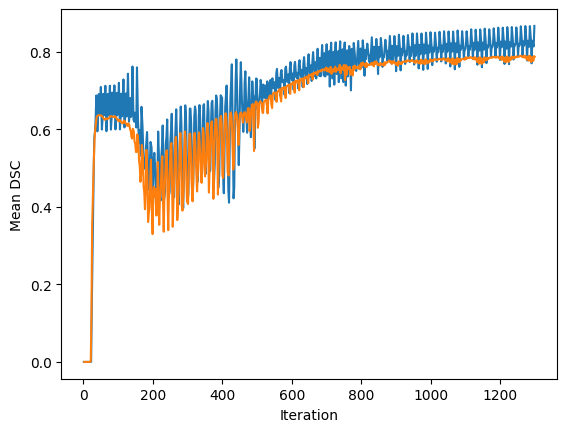

In [18]:
#plt.plot(dat_train.dsc_mean.dropna())
plt.plot(dat_train_batch.dsc_mean.dropna())
plt.plot(dat_test.dsc_mean.dropna())
plt.xlabel('Iteration')
plt.ylabel('Mean DSC')


Text(0, 0.5, 'Loss')

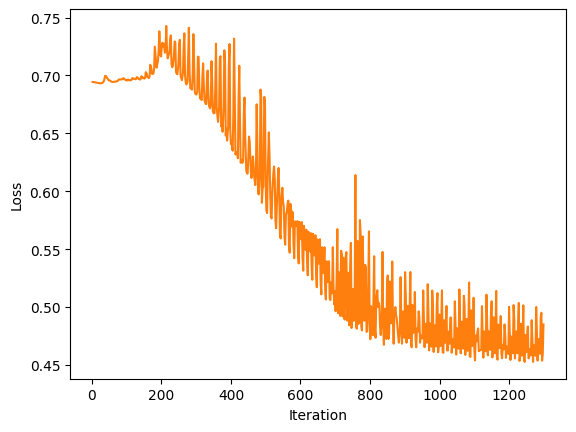

In [19]:
plt.plot(dat_train.loss.dropna())
plt.plot(dat_test.loss.dropna())
plt.xlabel('Iteration')
plt.ylabel('Loss')


In [20]:
dat_test.dsc_mean.max()

0.7898508310317993

In [21]:
dsc

array([0.88138574, 0.6942396 , 0.8076614 , 0.8441918 , 0.8175308 ,
       0.83353144, 0.7610574 , 0.8770524 , 0.874369  , 0.6950661 ,
       0.57888347, 0.8634908 , 0.69738376, 0.540884  , 0.5804967 ,
       0.90456945, 0.70511675, 0.6666667 , 0.78477836, 0.8178416 ,
       0.7088323 , 0.775724  , 0.70351493, 0.72204983, 0.77876854,
       0.8897387 , 0.78565615, 0.7363336 , 0.7800261 , 0.8967028 ,
       0.92333555, 0.7015561 , 0.8372488 , 0.71239173, 0.89438105,
       0.8366482 , 0.8568335 , 0.8606174 , 0.60460585, 0.78890705,
       0.53184545, 0.8029717 , 0.86347306, 0.9264131 , 0.7275351 ,
       0.8627191 , 0.7581885 , 0.8479625 , 0.72190624, 0.8903943 ,
       0.83321905, 0.92209166, 0.62842137, 0.7174586 , 0.84738547,
       0.87009335, 0.884058  , 0.8358171 , 0.8673035 , 0.8626283 ],
      dtype=float32)

In [22]:
dsc

array([0.88138574, 0.6942396 , 0.8076614 , 0.8441918 , 0.8175308 ,
       0.83353144, 0.7610574 , 0.8770524 , 0.874369  , 0.6950661 ,
       0.57888347, 0.8634908 , 0.69738376, 0.540884  , 0.5804967 ,
       0.90456945, 0.70511675, 0.6666667 , 0.78477836, 0.8178416 ,
       0.7088323 , 0.775724  , 0.70351493, 0.72204983, 0.77876854,
       0.8897387 , 0.78565615, 0.7363336 , 0.7800261 , 0.8967028 ,
       0.92333555, 0.7015561 , 0.8372488 , 0.71239173, 0.89438105,
       0.8366482 , 0.8568335 , 0.8606174 , 0.60460585, 0.78890705,
       0.53184545, 0.8029717 , 0.86347306, 0.9264131 , 0.7275351 ,
       0.8627191 , 0.7581885 , 0.8479625 , 0.72190624, 0.8903943 ,
       0.83321905, 0.92209166, 0.62842137, 0.7174586 , 0.84738547,
       0.87009335, 0.884058  , 0.8358171 , 0.8673035 , 0.8626283 ],
      dtype=float32)

In [23]:
dsc.mean().item()

0.7870324850082397

In [24]:
X.dtype

torch.float32